In [2]:
%load_ext autoreload
%autoreload 2
    
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
from utils import double_division_tracks, curated_tracks, DATA_ROOT

import pickle
import numpy as np
import pandas as pd
from pathlib import Path
import cv2

%matplotlib inline
import matplotlib.cm as cm
from matplotlib import pyplot as plt
plt.style.use('_classic_test')

from notebook_functions import umap_transform, plot_distributions,\
                timelapse_single_frame_sync, timelapse_double_frame_sync,\
                circular_tracking, normalize_intensities, project_onto_fluo_plane

log_const = 300

Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [3]:
with open(DATA_ROOT / 'descriptors.r34.sz48.pkl', 'rb') as f:
    y, descriptors, intensities, df_index = pickle.load(f)
descriptors = np.log(descriptors + 1e-7)
intensities = np.log(intensities + log_const)
print(y.shape, descriptors.shape, intensities.shape)

(9753, 4) (9753, 4) (9753, 2)


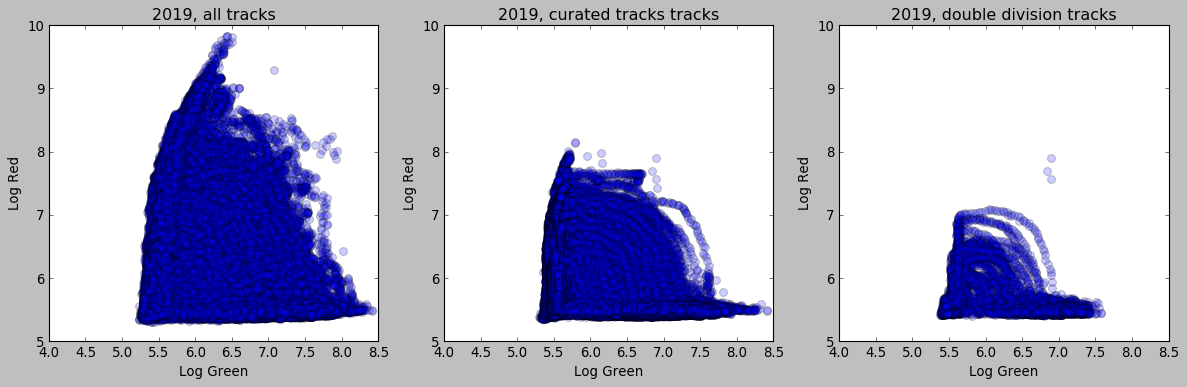

In [17]:
cell_df = pd.read_csv(DATA_ROOT / 'statistics_mean_std.bak.csv')
intensities_all = cell_df[['GFP_20', 'Cy3_20']].values
intensities_all = np.log(intensities_all + log_const)

intensities_curated_tracks = cell_df.loc[cell_df['TRACK_ID'].isin(curated_tracks), ['GFP_20', 'Cy3_20']].values
intensities_curated_tracks = np.log(intensities_curated_tracks + log_const)

intensities_double_division = cell_df.loc[cell_df['TRACK_ID'].isin(double_division_tracks), ['GFP_20', 'Cy3_20']].values
intensities_double_division = np.log(intensities_double_division + log_const)


plot_distributions(
    (intensities_all, '2019, all tracks'),
    (intensities_curated_tracks, '2019, curated tracks tracks'),
    (intensities_double_division, '2019, double division tracks')
)

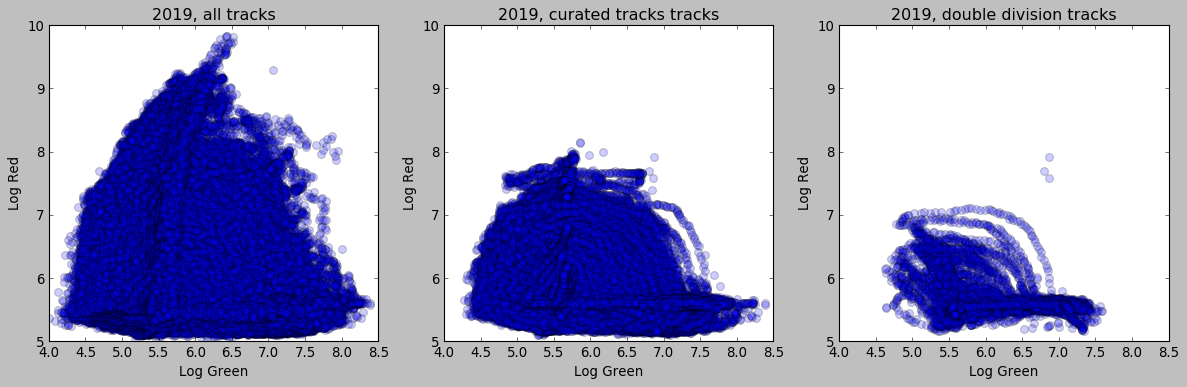

In [18]:
cell_df = pd.read_csv(DATA_ROOT / 'statistics_mean_std.csv')
intensities_all = cell_df[['GFP_20', 'Cy3_20']].values
intensities_all = np.log(intensities_all + log_const)

intensities_curated_tracks = cell_df.loc[cell_df['TRACK_ID'].isin(curated_tracks), ['GFP_20', 'Cy3_20']].values
intensities_curated_tracks = np.log(intensities_curated_tracks + log_const)

intensities_double_division = cell_df.loc[cell_df['TRACK_ID'].isin(double_division_tracks), ['GFP_20', 'Cy3_20']].values
intensities_double_division = np.log(intensities_double_division + log_const)


plot_distributions((intensities_all, '2019, all tracks'),
                   (intensities_curated_tracks, '2019, curated tracks tracks'),
                   (intensities_double_division, '2019, double division tracks'))

## Timelapse

In [15]:
# 'intensities.csv' contains ~1000 tracks synchronized on division event in 'time' column
df = pd.read_csv(DATA_ROOT / 'intensities.csv', header=[0, 1, 2])

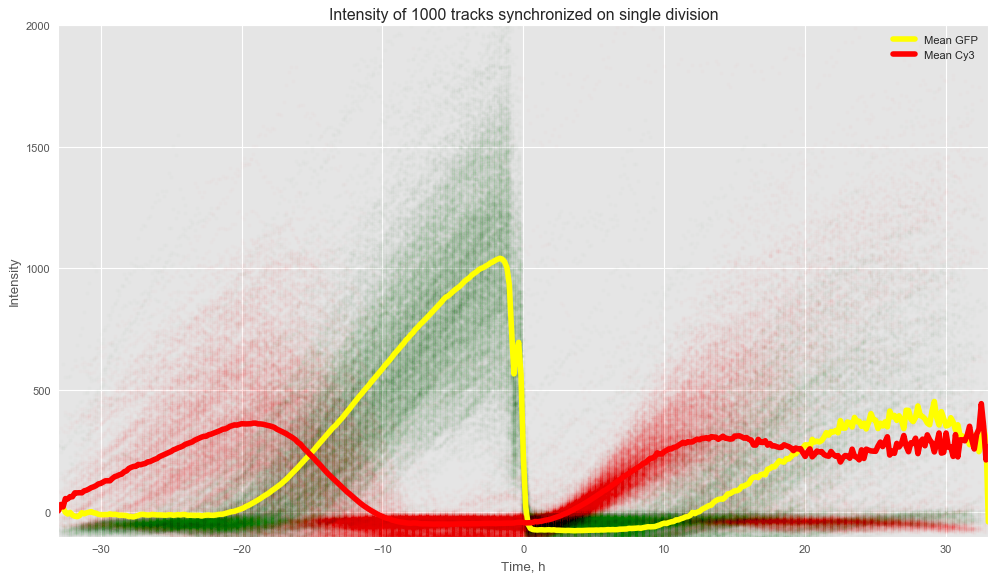

In [16]:
average_single_division_track = timelapse_single_frame_sync(df, curated_tracks)

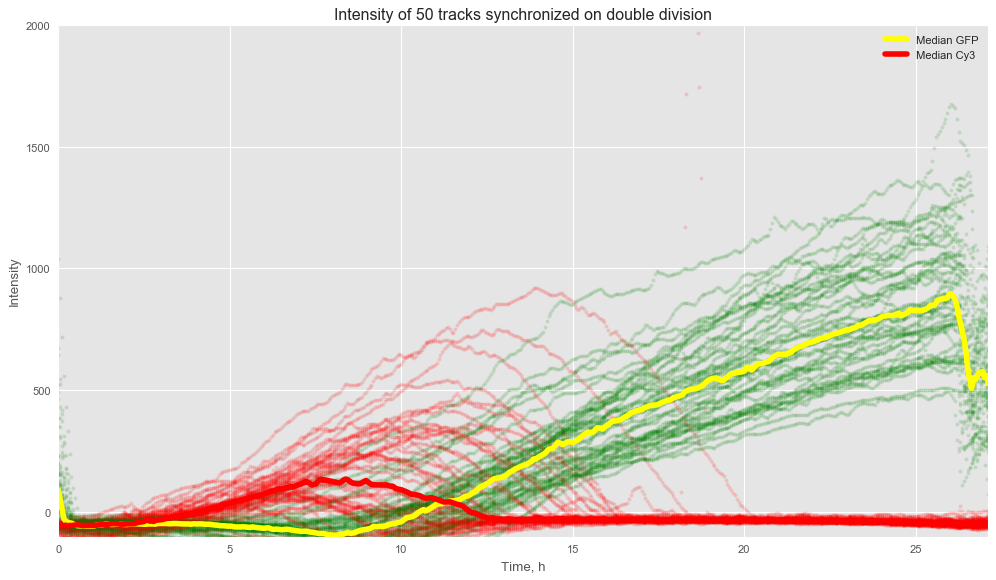

In [17]:
average_double_division_track, ax, _ = timelapse_double_frame_sync(df, double_division_tracks, nnods=500)

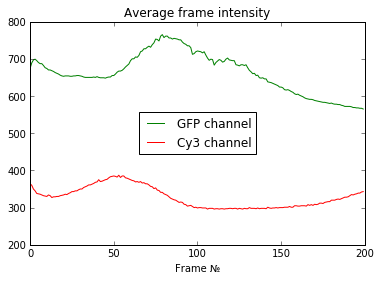

In [6]:
g_mean_tl, r_mean_tl = df[['gfp_frame_average', 'cy3_frame_average']].T.values

plt.plot(g_mean_tl, 'g', label='GFP channel')
plt.plot(r_mean_tl, 'r', label='Cy3 channel')
plt.legend(loc = 'center')
plt.title('Average frame intensity')
plt.xlabel('Frame №')
plt.show()

## U-Map embedding

update_title_pos
findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf') with score of 0.050000.
update_title_pos
update_title_pos
update_title_pos
update_title_pos


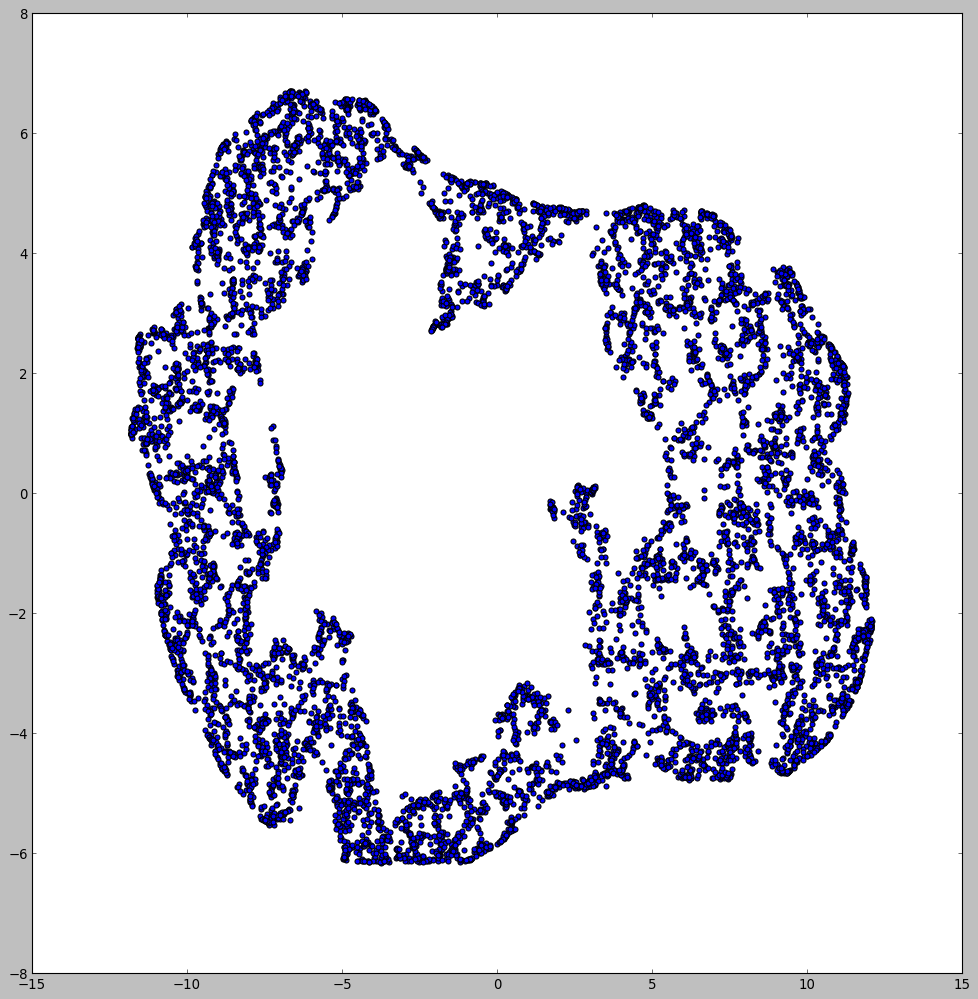

In [4]:
embeddings_preds, fit = umap_transform(descriptors, n_neighbors=300, min_dist=0.05, n_components=2, metric='correlation')

fig = plt.figure(figsize=(15, 15))
plt.scatter(embeddings_preds[:, 0], embeddings_preds[:, 1])

## Finding average track with circular binning

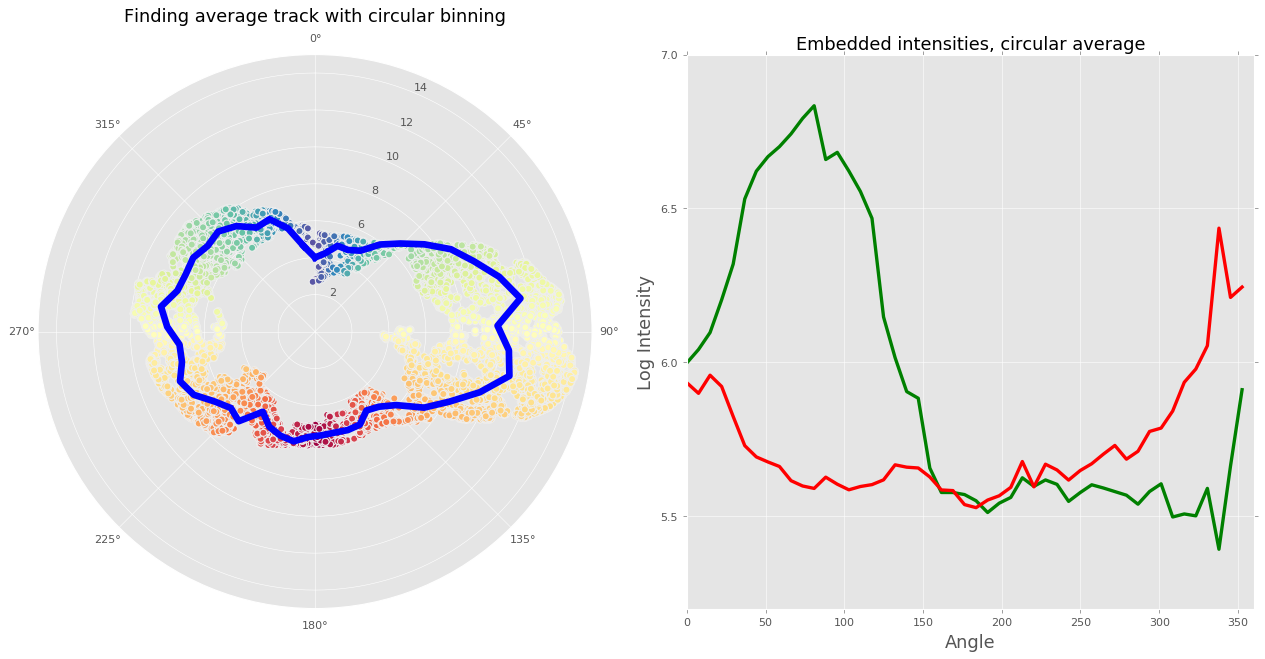

In [11]:
angle, radius, intensities_mean, embeddings_mean, angle_mean = circular_tracking(intensities, embeddings_preds, center_x=-2, center_y=0, steps=50)

fig = plt.figure(figsize=(16, 8))
plt.style.use('ggplot')

ax = fig.add_subplot(121, projection="polar")
ax.scatter(angle / 180 * np.pi, radius, s=40, cmap="Spectral", alpha=1, linewidths=1, c=np.abs(angle - 180))
ax.plot(angle_mean / 180 * np.pi, embeddings_mean, '-', linewidth=6, c='blue')
ax.plot([(angle_mean / 180 * np.pi)[-1], (angle_mean / 180 * np.pi)[0]], [embeddings_mean[-1], embeddings_mean[0]], '-', linewidth=6, c='blue')

ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_ylim(0, 15)
ax.set_title('Finding average track with circular binning', fontsize=16)

tick_labels = np.linspace(0, 360, len(intensities_mean), endpoint=False)
ax = fig.add_subplot(122)
ax.plot(tick_labels, intensities_mean[:, 0], c='green', linewidth=3)
ax.plot(tick_labels, intensities_mean[:, 1], c='red', linewidth=3)
ax.set_ylabel('Log Intensity', fontsize=16)
ax.set_xlabel("Angle", fontsize=16)
ax.set_xlim((0, 360))
ax.set_title('Embedded intensities, circular average', fontsize=16)

plt.tight_layout()

### Smoothed and normalized intensities

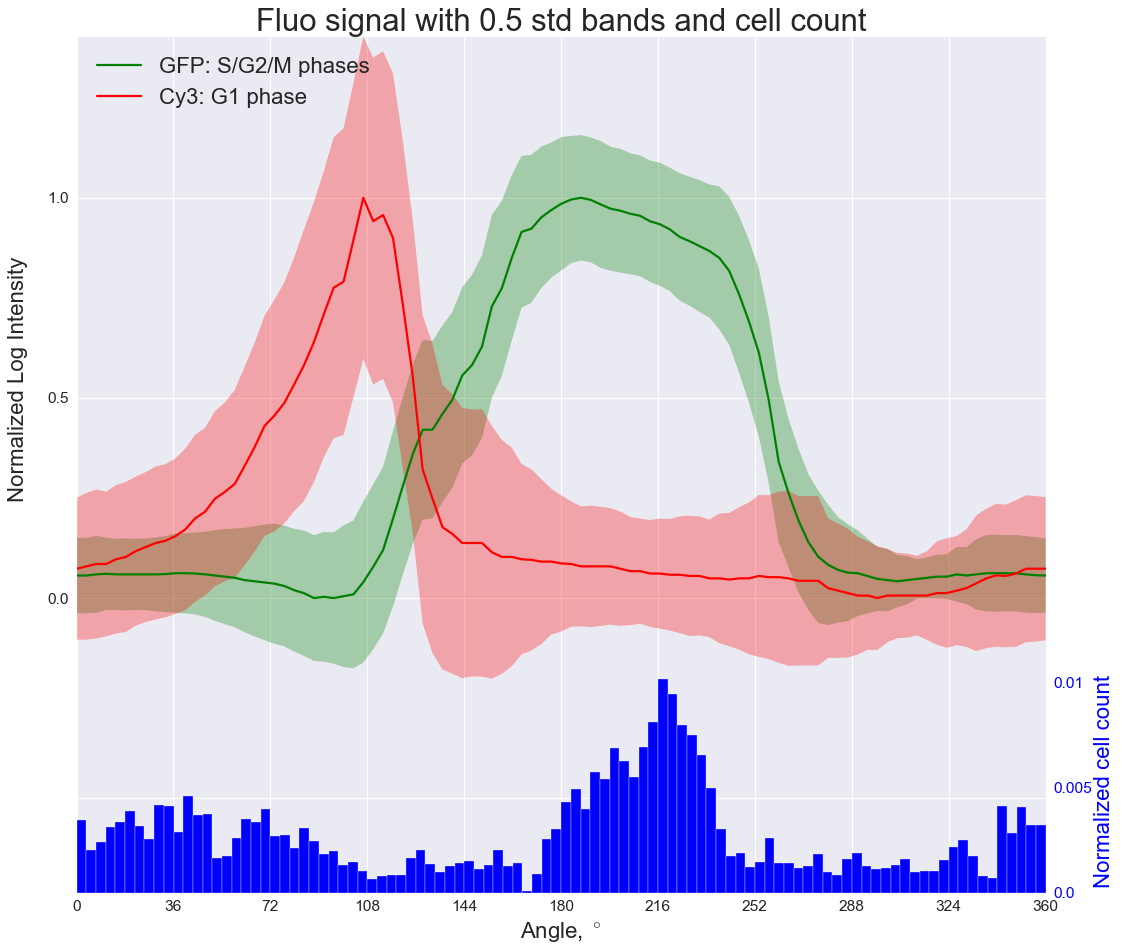

In [12]:
smoothed_track = normalize_intensities(intensities, angle, angle_shift=120)

## Project embedded trajectory onto fluo plane

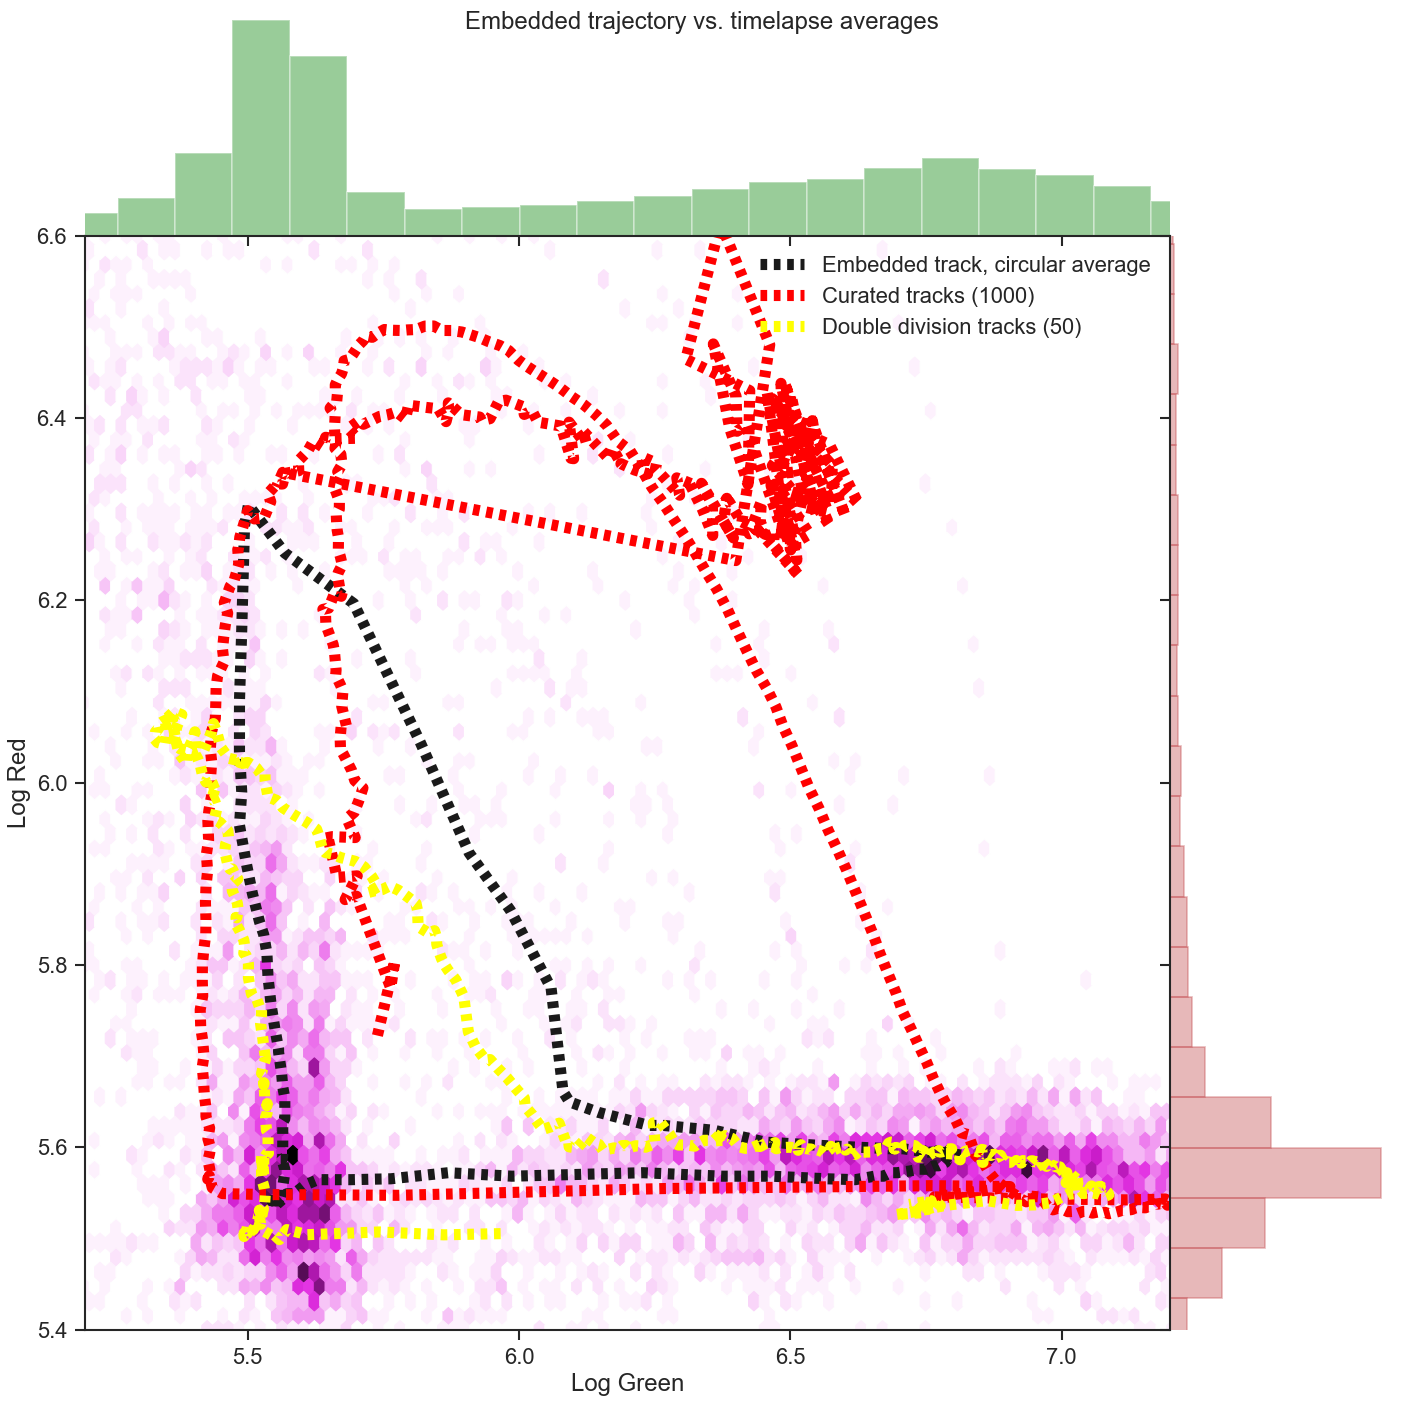

In [184]:
project_onto_fluo_plane(intensities, 
                        (smoothed_track, 'k', 'Embedded track, circular average'), 
                        (np.log(average_single_division_track + log_const), 'red', 'Curated tracks (1000)'), 
                        (np.log(average_double_division_track + log_const), 'yellow', 'Double division tracks (50)'), 
                        log_const=300)

## Finding average track with SOM clustering

In [5]:
import sompy
mapsize = 30
som = sompy.SOMFactory.build(embeddings_preds, mapsize, mask=None, mapshape='cylinder', lattice='rect',
                             normalization='None', initialization='spherical', neighborhood='gaussian',
                             training='batch', name='sompy', track_history=True)
som.train(n_job=1, verbose=None)

som_matrix = som.codebook.matrix
som_bmu = som._bmu[0].astype(int)

input was considered as the numbers of nodes
map size is [1,30]


In [6]:
som_translation_tbl = np.roll(sorted(np.unique(som_bmu))[::-1], -5)

som_matrix = som_matrix[som_translation_tbl]
som_bmu = som_translation_tbl[som_bmu]

In [7]:
fun = np.median
som_track = []
for cluster in np.sort(np.unique(som_bmu)):
    som_track.append(fun(intensities[som_bmu == cluster], 0))
som_track = np.array(som_track)
# som_track = np.roll(som_track[::-1], -5, axis=0)

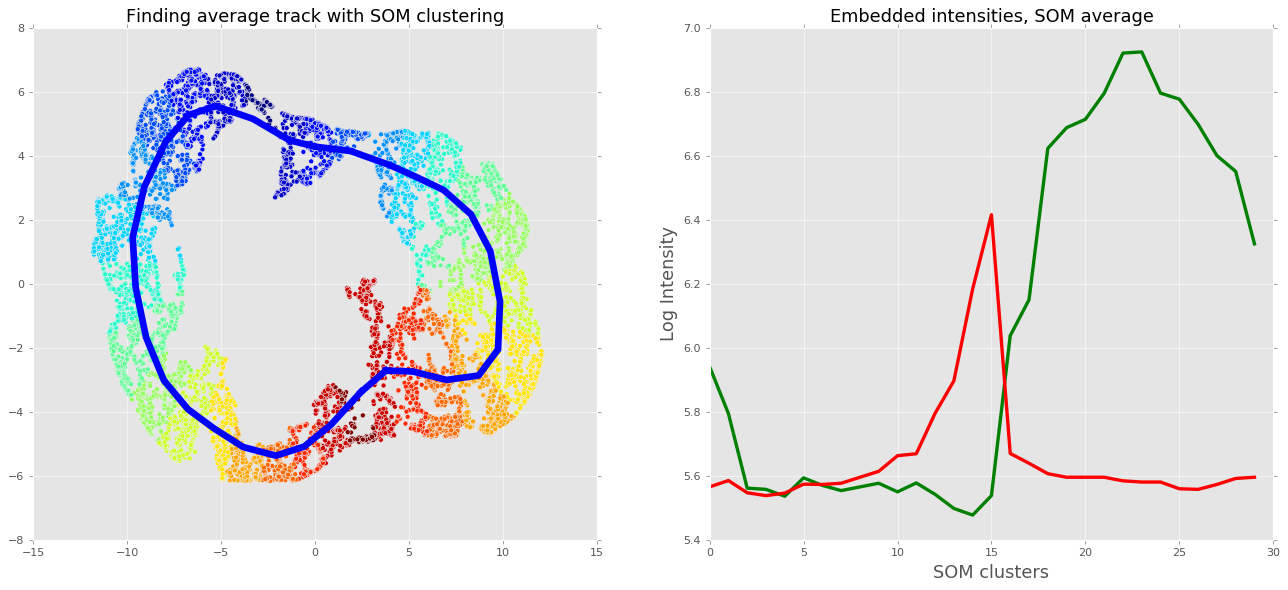

In [8]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(20, 8))

color = 'blue'
ax = fig.add_subplot(121)
ax.scatter(embeddings_preds[:,0], embeddings_preds[:,1], c=np.abs(som_bmu - mapsize / 2))
ax.plot(som_matrix[:,0], som_matrix[:,1], '-', linewidth=6, c=color)
ax.plot([som_matrix[-1, 0], som_matrix[0, 0]], [som_matrix[-1, 1], som_matrix[0, 1]], '-', linewidth=6, c=color)
ax.set_title('Finding average track with SOM clustering', fontsize=16)

ax = fig.add_subplot(122)
ax.plot(som_track[:, 0], c='green', linewidth=3)
ax.plot(som_track[:, 1], c='red', linewidth=3)
ax.set_ylabel('Log Intensity', fontsize=16)
ax.set_xlabel('SOM clusters', fontsize=16)
ax.set_title('Embedded intensities, SOM average', fontsize=16)


plt.show()

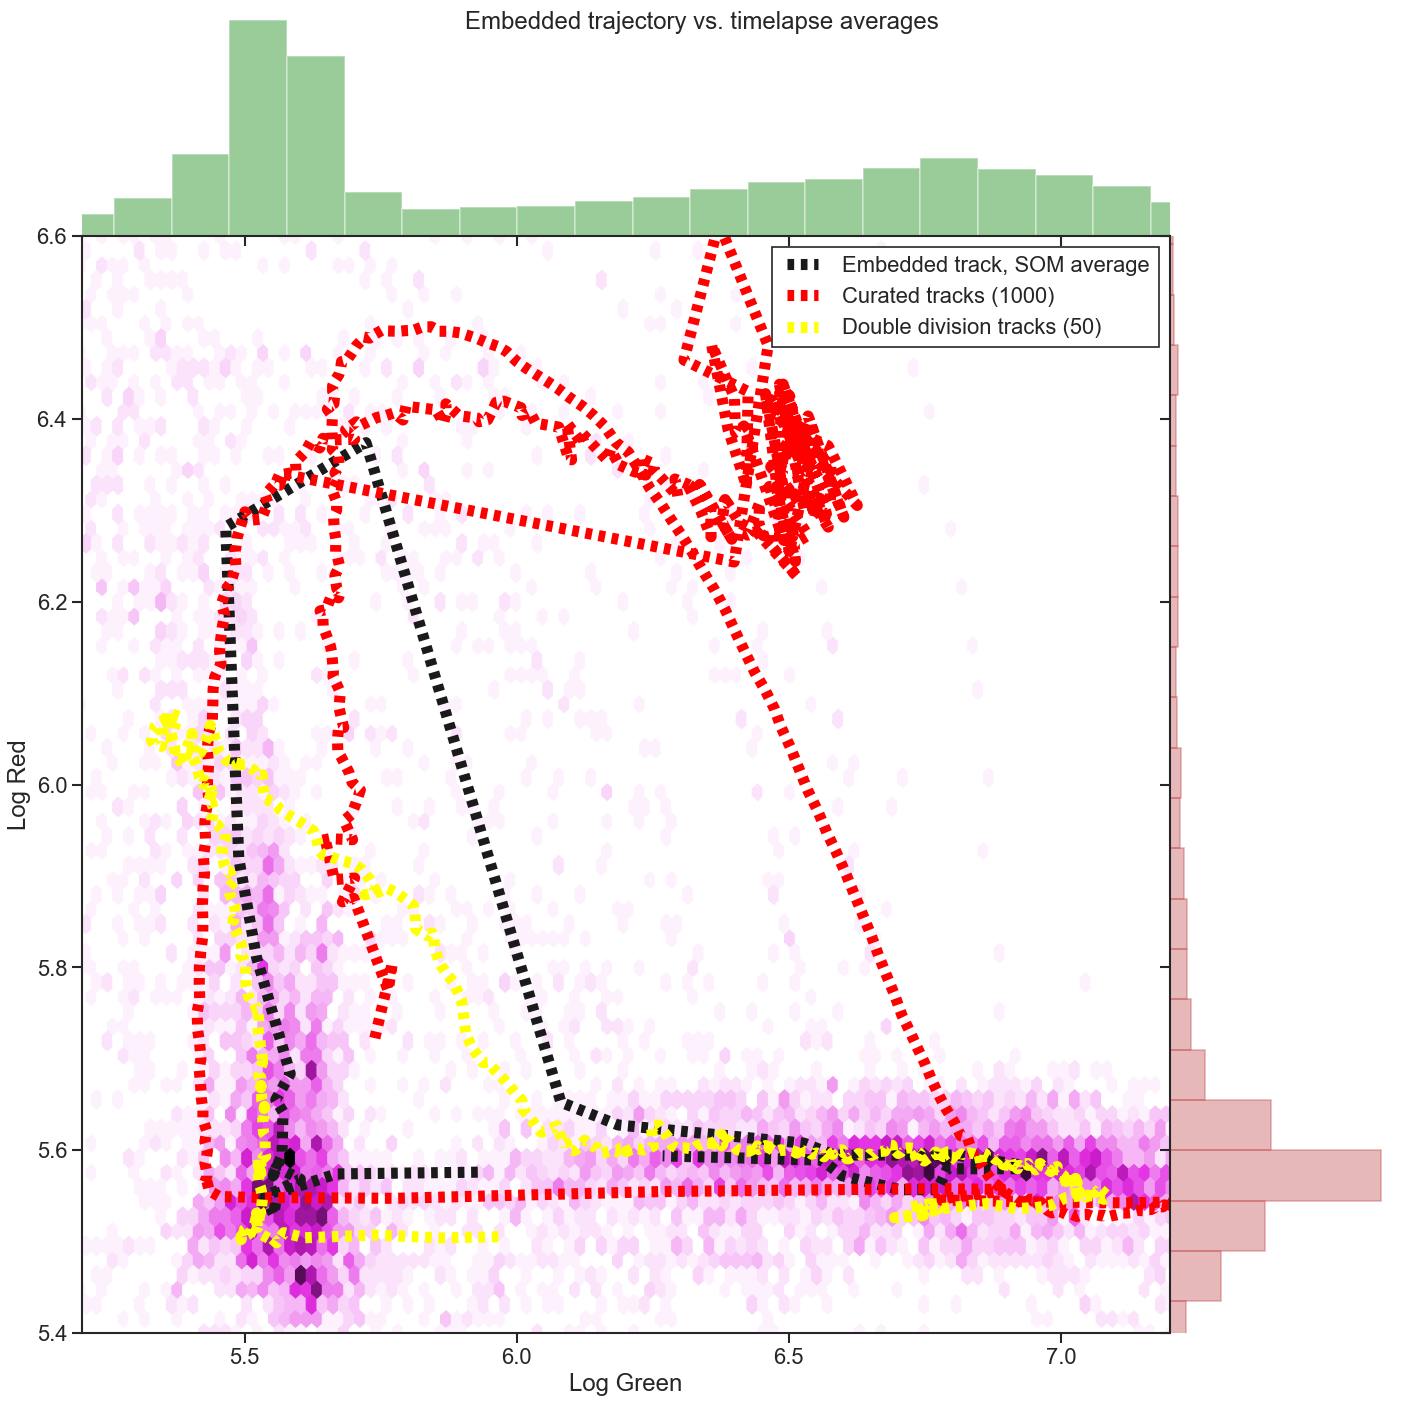

In [318]:
project_onto_fluo_plane(intensities, 
                        (som_track, 'k', 'Embedded track, SOM average'), 
                        (np.log(average_single_division_track + log_const), 'red', 'Curated tracks (1000)'), 
                        (np.log(average_double_division_track + log_const), 'yellow', 'Double division tracks (50)'), 
                        log_const=300)

# Time calibration

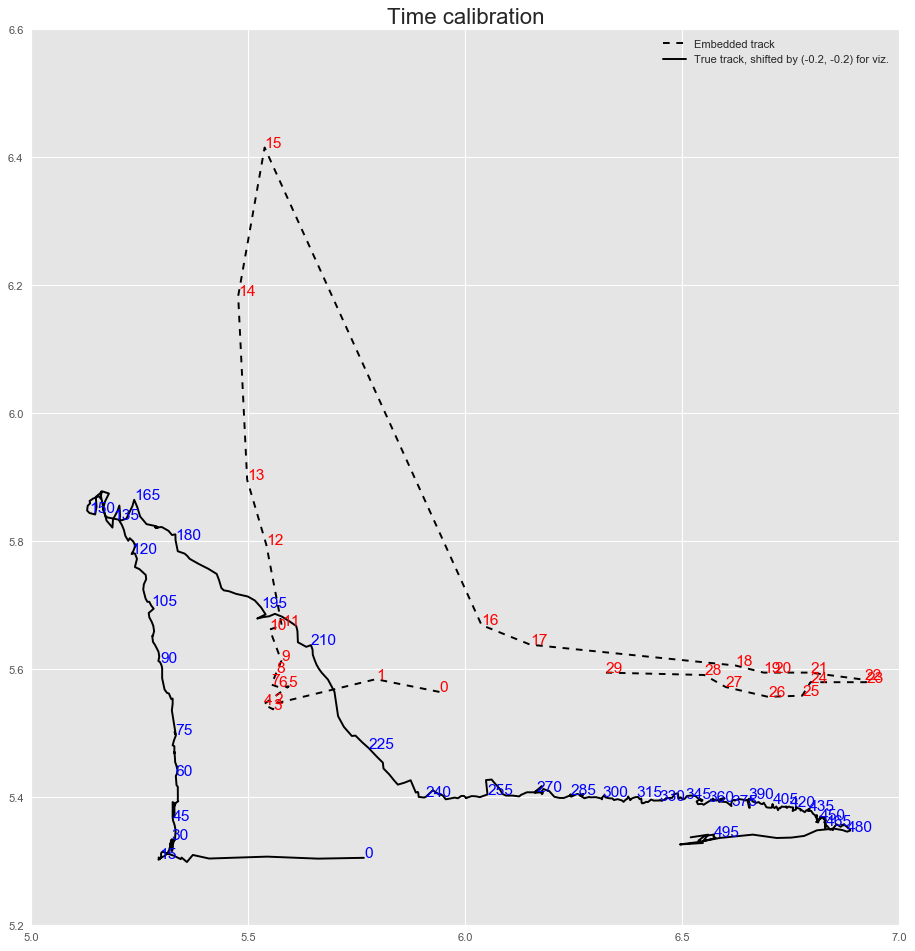

In [18]:
fontsize = 14
plt.style.use('ggplot')

plt.figure(figsize=(14, 14))
plt.plot(som_track[:, 0], som_track[:, 1], 'k', linestyle='--', label='Embedded track')
for i, xy in enumerate(som_track):
    plt.annotate(str(i), xy, fontsize=fontsize, color='r')


shift = (-0.2, -0.2)
true_track = np.log(average_double_division_track + log_const) + shift
plt.plot(true_track[:, 0], true_track[:, 1], 'k', linestyle='-', label=f'True track, shifted by ({shift[0]}, {shift[1]}) for viz.')

for i, xy in enumerate(true_track):
    if (i % 15) != 0:
        continue
    plt.annotate(str(i), xy, fontsize=fontsize, color='b')

plt.title('Time calibration', fontsize=20)
plt.legend()
plt.show()

In [19]:
time_calibration = {
    0: 0,
    3: 15,
    14: 150,
    15: 165,
    16: 240,
    23: 480,
    26: 495,
}

dd_frames = np.array(list(double_division_tracks.values()))
average_track_duration = np.mean(dd_frames[:, 1] - dd_frames[:, 0]) * 10 / 60  # hours
print(f'Average track duration {average_track_duration:.2f} hours')

Average track duration 27.12 hours


Text(0.5, 1.0, 'Interpolating embedded track time')

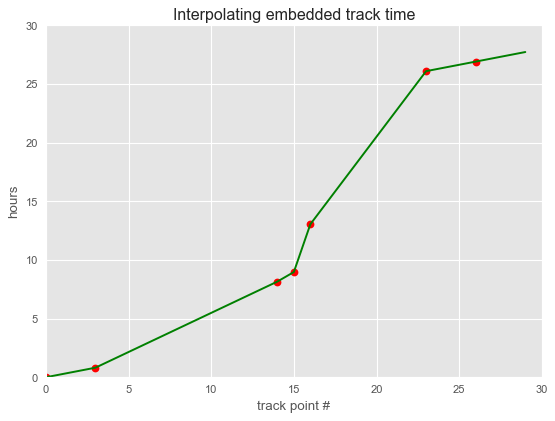

In [20]:
from scipy.interpolate import interp1d

embd_track_time = {v: average_track_duration / len(som_track) * k for k, v in time_calibration.items()}
x = np.array(sorted(time_calibration))
y = np.array([time_calibration[i] / (len(true_track) - 1) * average_track_duration for i in x])
f = interp1d(x, y, kind='linear', fill_value='extrapolate')
xnew = np.arange(len(som_track))
ynew = f(xnew)
plt.plot(x, y, 'ro', xnew, ynew, 'g-')
plt.xlabel('track point #')
plt.ylabel('hours')
plt.title('Interpolating embedded track time')

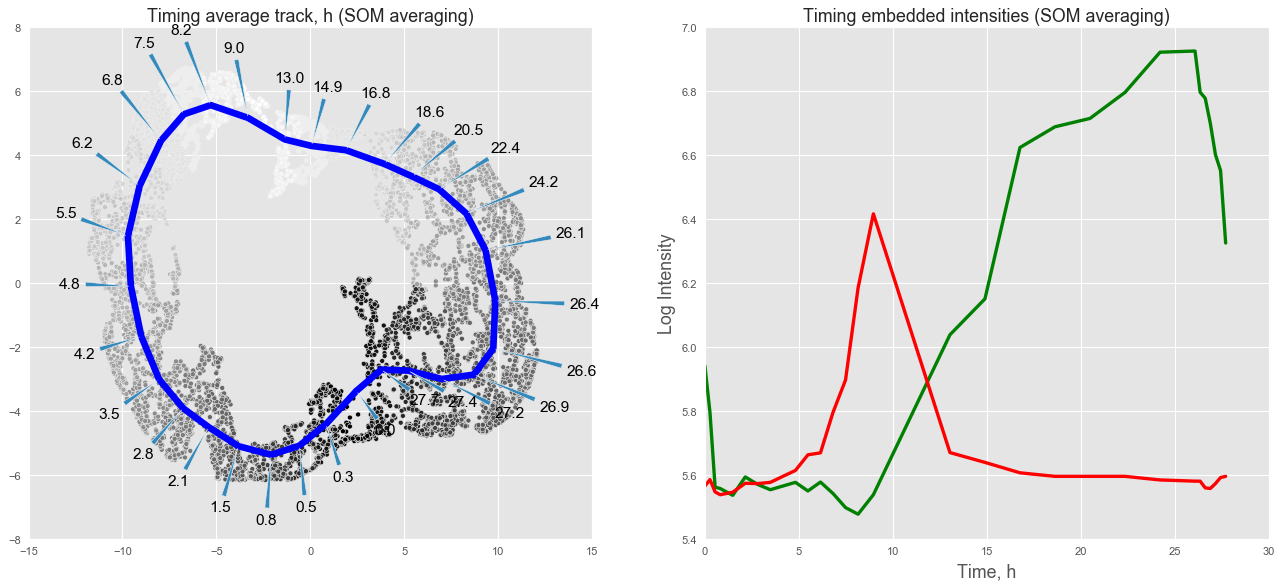

In [21]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(20, 8))

color = 'blue'
ax = fig.add_subplot(121)
ax.scatter(embeddings_preds[:,0], embeddings_preds[:,1], c=np.abs(som_bmu - mapsize / 2))
ax.plot(som_matrix[:,0], som_matrix[:,1], '-', linewidth=6, c=color)
ax.plot([som_matrix[-1, 0], som_matrix[0, 0]], [som_matrix[-1, 1], som_matrix[0, 1]], '-', linewidth=6, c=color)
ax.set_title('Timing average track, h (SOM averaging)', fontsize=16)

for h, xy in zip(ynew, som_matrix):
    angle = np.arctan(xy[1] / xy[0]) + (xy[0] < 0) * np.pi
    radius = np.sqrt(np.square(xy).sum())
    radius *= 1.4
    xy_ = np.array([np.cos(angle), np.sin(angle)]) * radius
    plt.annotate(f'{h:.1f}', xy=xy, xytext=xy_, fontsize=14, color='k', arrowprops={'arrowstyle': 'wedge'})
    
ax = fig.add_subplot(122)
ax.plot(ynew, som_track[:, 0], c='green', linewidth=3)
ax.plot(ynew, som_track[:, 1], c='red', linewidth=3)
ax.set_ylabel('Log Intensity', fontsize=16)
ax.set_xlabel('Time, h', fontsize=16)
ax.set_title('Timing embedded intensities (SOM averaging)', fontsize=16)


plt.show()

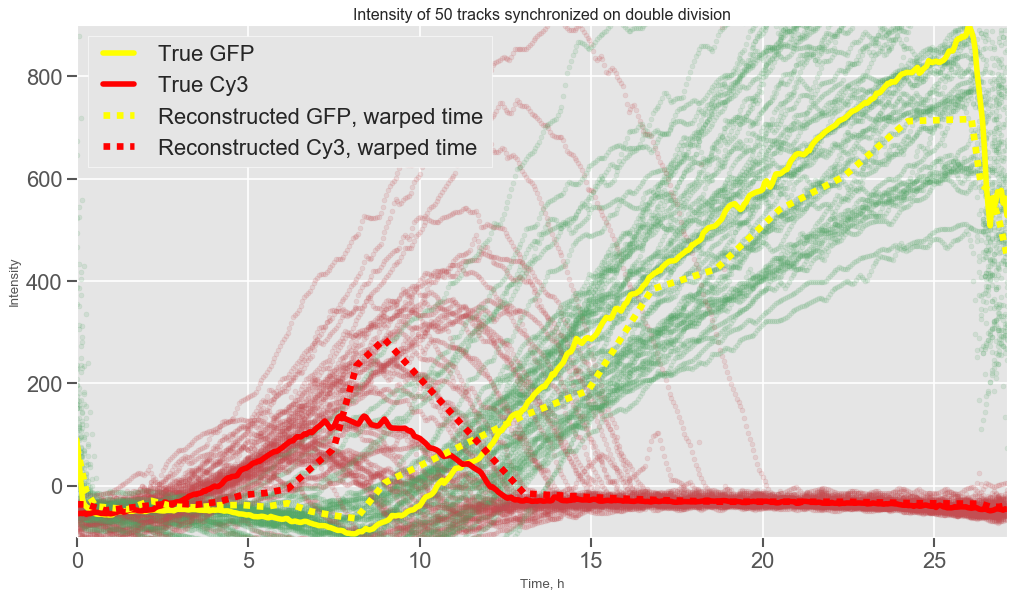

In [331]:
average_double_division_track, ax, _ = timelapse_double_frame_sync(df, double_division_tracks, nnods=500)
x_ = ax.lines[0].get_xdata()

f_green = interp1d(ynew, np.exp(som_track[:, 0]) - log_const, kind='linear', fill_value='extrapolate')
f_red = interp1d(ynew, np.exp(som_track[:, 1]) - log_const, kind='linear', fill_value='extrapolate')
y_green = f_green(x_)
y_red = f_red(x_)

ax.plot(x_, y_green, 'yellow', x_, y_red, 'red', linestyle='--', linewidth=6)
ax.set_ylim((-100, 900))
ax.legend(ax.lines[-4:], ['True GFP', 'True Cy3', 'Reconstructed GFP, warped time', 'Reconstructed Cy3, warped time'], loc=0)
plt.show()

# Time reconstruction

In [31]:
with open(DATA_ROOT / 'descriptors_all.r34.sz48.pkl', 'rb') as f:
    y_all, descriptors_all, intensities_all, df_index_all = pickle.load(f)
descriptors_all = np.log(descriptors_all + 1e-7)
intensities_all = np.log(intensities_all + log_const)
print(y_all.shape, descriptors_all.shape, intensities_all.shape)

(2684453, 4) (2684453, 4) (2684453, 2)


In [38]:
embeddings_preds_all = fit.transform(descriptors_all[::10])

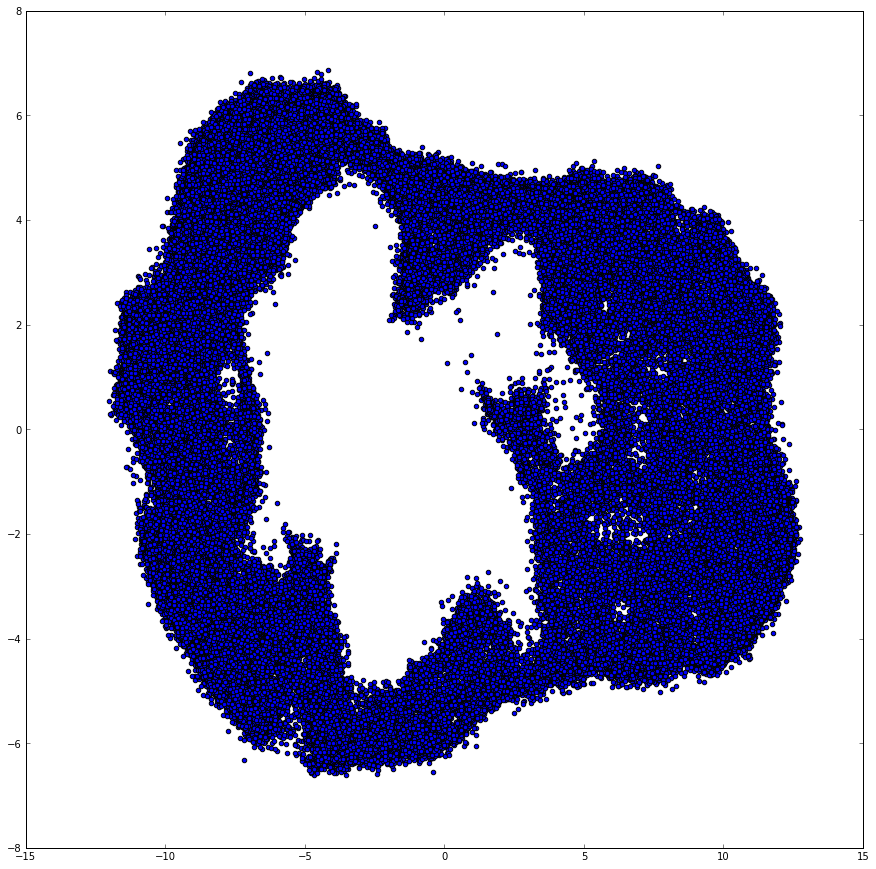

In [90]:
fig = plt.figure(figsize=(15, 15))
plt.scatter(embeddings_preds_all[:, 0], embeddings_preds_all[:, 1])

In [339]:
som_bmu_all = som_translation_tbl[som.project_data(embeddings_preds_all)]

In [363]:
# embeddings_50_df = pd.DataFrame.from_dict({'index': df_index.flatten(), 'embeddings_0': embeddings_preds[:, 0], 'embeddings_1': embeddings_preds[:, 1]})
embeddings_all_df = pd.DataFrame.from_dict({'index': df_index_all[::10].flatten(), 
                                            'embeddings_0': embeddings_preds_all[:, 0], 
                                            'embeddings_1': embeddings_preds_all[:, 1],
                                            'time': ynew[som_bmu_all]})

dfc = pd.read_csv(DATA_ROOT / 'statistics_mean_std.csv')
embeddings_all_df = embeddings_all_df.set_index('index').join(dfc[['POSITION_X', 'POSITION_Y']]).reset_index()
embeddings_all_df.to_csv(DATA_ROOT / 'embeddings_all.csv', index=False)

In [353]:
fun = np.median
som_track_all = []
for cluster in np.sort(np.unique(som_bmu_all)):
    som_track_all.append(fun(intensities_all[::10][som_bmu_all == cluster], 0))
som_track_all = np.array(som_track_all)

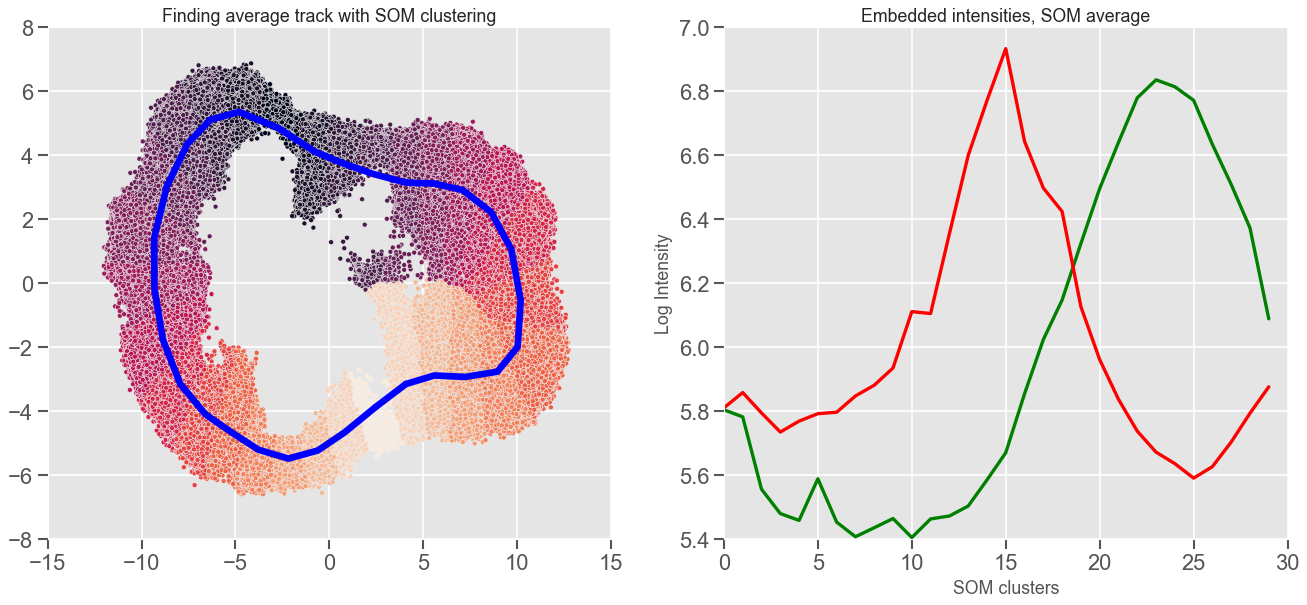

In [348]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(20, 8))

color = 'blue'
ax = fig.add_subplot(121)
ax.scatter(embeddings_preds_all[:,0], embeddings_preds_all[:,1], c=np.abs(som_bmu_all - mapsize / 2))
ax.plot(som_matrix[:,0], som_matrix[:,1], '-', linewidth=6, c=color)
ax.plot([som_matrix[-1, 0], som_matrix[0, 0]], [som_matrix[-1, 1], som_matrix[0, 1]], '-', linewidth=6, c=color)
ax.set_title('Finding average track with SOM clustering', fontsize=16)

ax = fig.add_subplot(122)
ax.plot(som_track_all[:, 0], c='green', linewidth=3)
ax.plot(som_track_all[:, 1], c='red', linewidth=3)
ax.set_ylabel('Log Intensity', fontsize=16)
ax.set_xlabel('SOM clusters', fontsize=16)
ax.set_title('Embedded intensities, SOM average', fontsize=16)


plt.show()

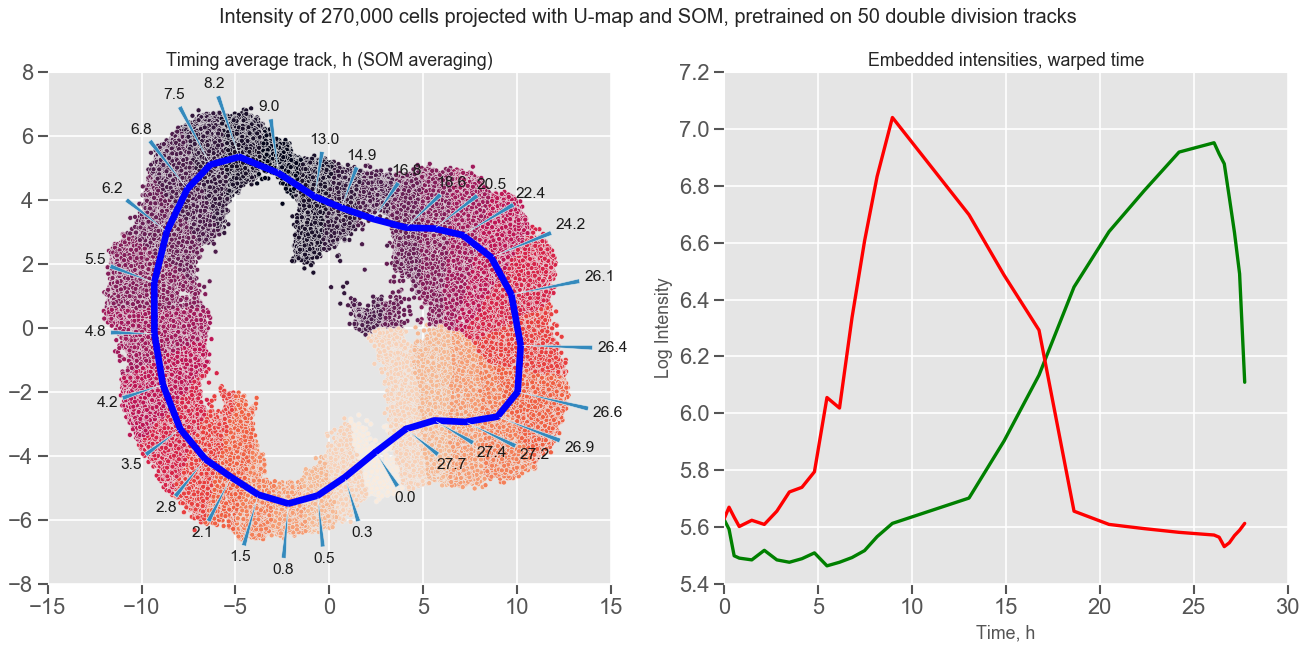

In [412]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(20, 8))

color = 'blue'
ax = fig.add_subplot(121)
ax.scatter(embeddings_preds_all[:,0], embeddings_preds_all[:,1], c=np.abs(som_bmu_all - mapsize / 2))
ax.plot(som_matrix[:,0], som_matrix[:,1], '-', linewidth=6, c=color)
ax.plot([som_matrix[-1, 0], som_matrix[0, 0]], [som_matrix[-1, 1], som_matrix[0, 1]], '-', linewidth=6, c=color)
ax.set_title('Timing average track, h (SOM averaging)', fontsize=16)

for h, xy in zip(ynew, som_matrix):
    angle = np.arctan(xy[1] / xy[0]) + (xy[0] < 0) * np.pi
    radius = np.sqrt(np.square(xy).sum())
    radius *= 1.4
    xy_ = np.array([np.cos(angle), np.sin(angle)]) * radius
    plt.annotate(f'{h:.1f}', xy=xy, xytext=xy_, fontsize=14, color='k', arrowprops={'arrowstyle': 'wedge'})
    
ax = fig.add_subplot(122)
ax.plot(ynew, som_track_all[:, 0], c='green', linewidth=3)
ax.plot(ynew, som_track_all[:, 1], c='red', linewidth=3)
ax.set_ylabel('Log Intensity', fontsize=16)
ax.set_xlabel('Time, h', fontsize=16)
ax.set_title('Embedded intensities, warped time', fontsize=16)

plt.suptitle('Intensity of 270,000 cells projected with U-map and SOM, pretrained on 50 double division tracks', 
             y=1.0, fontsize=18)
plt.show()

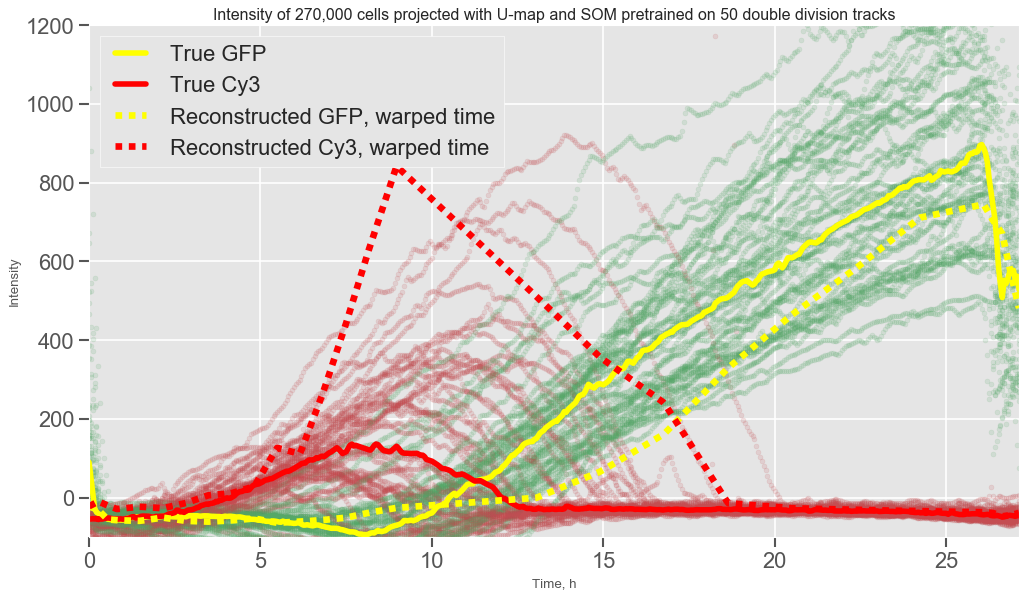

In [405]:
average_double_division_track, ax, _ = timelapse_double_frame_sync(df, double_division_tracks, nnods=500,
                                                                  title='Intensity of 270,000 cells projected with U-map and SOM pretrained on 50 double division tracks')
x_ = ax.lines[0].get_xdata()

f_green = interp1d(ynew, np.exp(som_track_all[:, 0]) - log_const, kind='linear', fill_value='extrapolate')
f_red = interp1d(ynew, np.exp(som_track_all[:, 1]) - log_const, kind='linear', fill_value='extrapolate')
y_green = f_green(x_)
y_red = f_red(x_)

ax.plot(x_, y_green, 'yellow', x_, y_red, 'red', linestyle='--', linewidth=6)
ax.set_ylim((-100, 1200))
ax.legend(ax.lines[-4:], ['True GFP', 'True Cy3', 'Reconstructed GFP, warped time', 'Reconstructed Cy3, warped time'], loc=0)
plt.show()

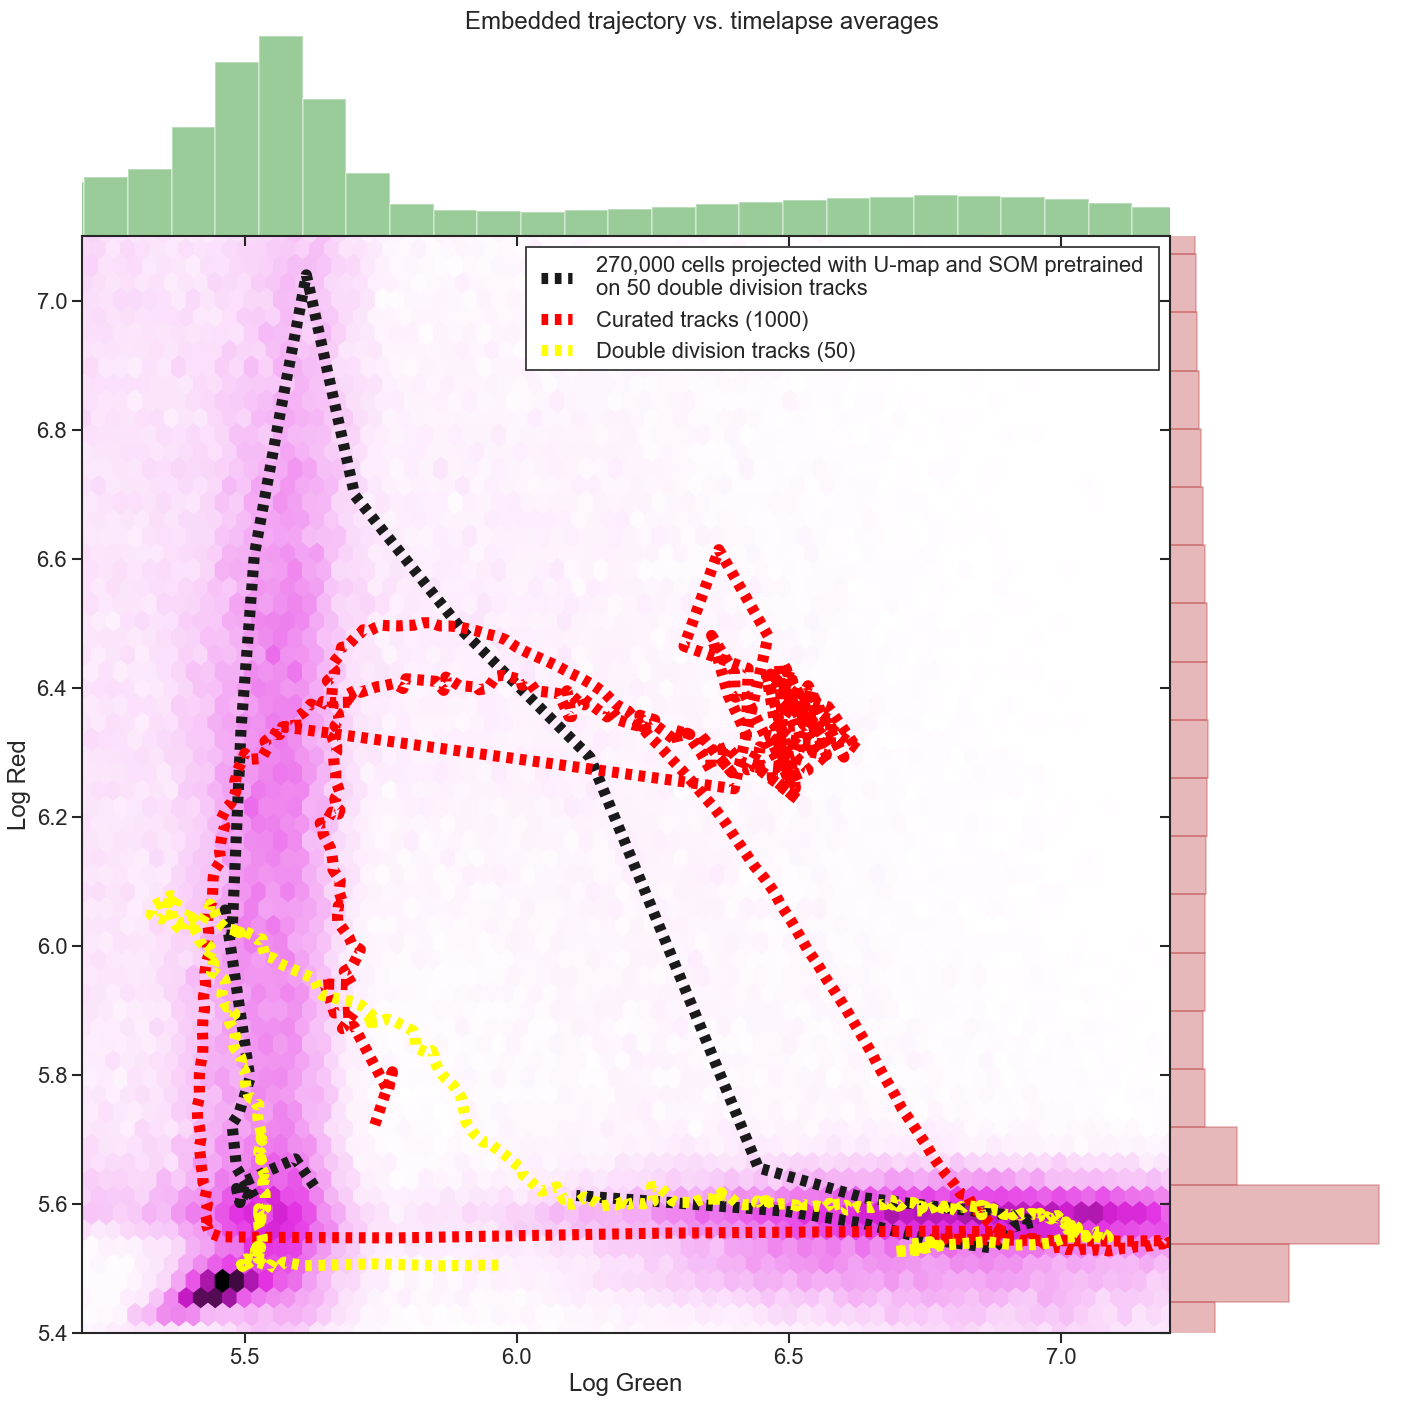

In [418]:
project_onto_fluo_plane(intensities_all[::10], 
                        (som_track_all, 'k', '270,000 cells projected with U-map and SOM pretrained \non 50 double division tracks'), 
                        (np.log(average_single_division_track + log_const), 'red', 'Curated tracks (1000)'), 
                        (np.log(average_double_division_track + log_const), 'yellow', 'Double division tracks (50)'), 
                        log_const=300)

In [414]:
intensities_all.shape

(2684453, 2)